# Part 1: Data cleaning and preliminary EDA

Welcome to my data analysis (EDA) project! In this project, we will be analyzing the "Beer Reviews" dataset from Kaggle, uploaded by user "Datadoume". Our ultimate goal will be the construction of a beer recommendation algorithm. This dataset contains data from ~1.5 million beer reviews from the website "Beer Advocate". 

In [74]:
%%capture
import scipy as sp
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
#We're going to load duckdb in order to run SQL queries on our data set
import duckdb as db

In [75]:
# Download latest version
path = kagglehub.dataset_download("rdoume/beerreviews", path='beer_reviews.csv', force_download = True)

beer = pd.read_csv(path)

100%|██████████| 27.4M/27.4M [00:06<00:00, 4.68MB/s]


Let's take a quick look at our data.

In [76]:
print(len(beer))
beer.head()

1586614


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


We can see that each row represents a review ranking a beer on several qualities including an overall score. We also have some basic information about each beer reviewed, such as its type and the brewery producing the beer. Finally, we have some metadata: the date the review was posted, the username of the the user who posted the review, and unique identifiers for the breweries/beers. For the purposes of our analysis, we'll keep all the columns since they could all be useful.

Now let's see how many rows have missing values.

In [77]:
#sum rows with one or more null values
beer.isna().sum()

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64

We can see from the above output that around 68000 rows have one or more null values and most of the missing values are the ABV (alcohol by volume). Since the number of rows with null values is low compared to the size of the  data set, in this case, we'll opt to discard the null values (we are going to use ABV in our analysis).

In [78]:
#remove nulls
beer = beer[-beer.isna().any(axis=1)]

We'll also look for duplicates in the data.

In [79]:
beer.duplicated().sum()

np.int64(0)

Looks like we're good; no duplicates. At this point, we're ready to begin doing some preliminary analysis of the data. Let's take a look at the review scores first.

In [80]:
#subset data
cols = ["review_overall", "review_aroma", "review_appearance",
        "review_palate", "review_taste"]
round(beer[cols].describe(), 2)

,review_overall,review_aroma,review_appearance,review_palate,review_taste
count,1518478.00,1518478.00,1518478.00,1518478.00,1518478.00
mean,3.82,3.75,3.85,3.75,3.80
std,0.72,0.70,0.61,0.68,0.73
min,0.00,1.00,0.00,1.00,1.00
25%,3.50,3.50,3.50,3.50,3.50
50%,4.00,4.00,4.00,4.00,4.00
75%,4.50,4.00,4.00,4.00,4.50
max,5.00,5.00,5.00,5.00,5.00


/var/folders/b6/811_kpyj6yd5q_vzydsq8cbc0000gn/T/ipykernel_13251/3967134386.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


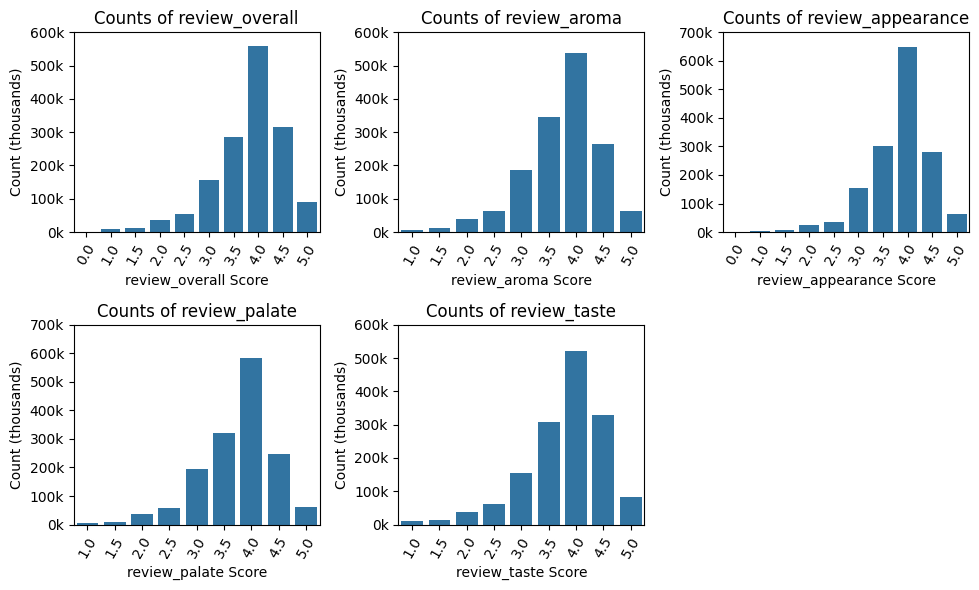

In [81]:
#create a subplots figure + axes
fig, axes = plt.subplots(2,3, figsize=(10,6))
#makes axes 1D
axes = axes.flatten()
#loop over axes and plot
for i in range(5):
        ax = axes[i]
        key = cols[i]
        sb.countplot(data=beer, x=cols[i], ax=ax)
        ax.tick_params(axis='x', rotation=60)
        ax.set_title(f'Counts of {key}')
        yticks = ax.get_yticks()
        ylabels = [f'{int(tick/1000)}k' for tick in yticks]
        ax.set_yticks(yticks)
        ax.set_yticklabels(ylabels)
        ax.set_ylabel('Count (thousands)')
        ax.set_xlabel(f'{key} Score')
#show results
fig.tight_layout()
fig.delaxes(axes[5])
fig.show()

We can see from the above results that the distribution for each score is similar - 4.0 is the most common score, with scores of 5.0 or 2.5 and below being quite uncommon. All the score distributions exhibit left skew. Let's look at ABV now.

In [82]:
#perform basic analysis at ABV data
round(beer['beer_abv'].describe(), 2)

count    1518478.00
mean           7.04
std            2.32
min            0.01
25%            5.20
50%            6.50
75%            8.50
max           57.70
Name: beer_abv, dtype: float64

We can see that there is a large range between the maximum and minimum values. Let's take a closer look at what a "typical" ABV value looks like.

In [83]:
quants = beer['beer_abv'].quantile([.5,.95])
quants

0.50     6.5
0.95    11.0
Name: beer_abv, dtype: float64

We can see that 90% of beers have ABV values between 0.95 and 11. Let's take a look at the distribution of beers within this range.

Text(0.5, 1.0, 'ABV Counts')

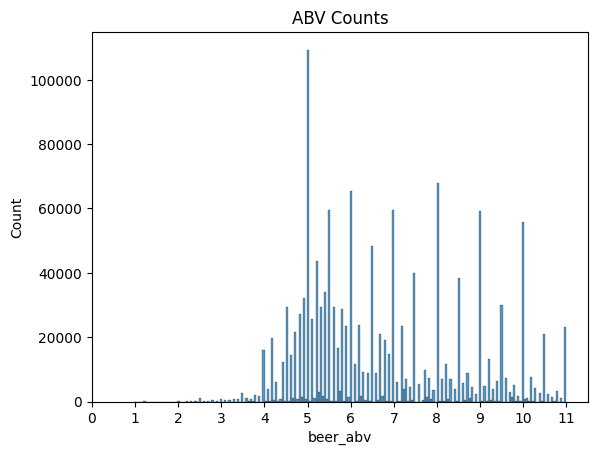

In [84]:
#let's plot the abv counts
ax = sb.histplot(data=beer, x='beer_abv', binrange=(.95,11))
ticks = list(range(12))
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.set_title('ABV Counts')

It appears that beers with an ABV of 5 are the most common. It also appears that whole numbers are better represented. For fun, let's take a look at beer with the highest ABV.

In [85]:
#find most alcoholic beer
beer.loc[beer['beer_abv'] == max(beer['beer_abv'])]

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
12919,6513,Schorschbräu,1316780901,4.0,4.0,4.0,kappldav123,Eisbock,4.0,3.5,Schorschbräu Schorschbock 57%,57.7,73368


A quick search indicates that this beer is real! Honestly, I would be very curious to try it.

We may also be curious about the category data.

In [86]:
#how many categories are there?
beer['beer_style'].nunique()

104

The relatively small number of categories compared to the size of the overall dataset is a good sign; we expect that there shouldn't be too many mistyped/erroneous categories, if any. Let's take a quick look at the categories and some basic information about them.

In [112]:
#we'll run a SQL queries to group the data by beer style and generate some statistics
query = "SELECT beer_style, COUNT(DISTINCT beer_beerid) num_beers, \
    COUNT(*) as review_count, AVG(review_overall) as avg_rating, \
    MAX(beer_abv) as max_abv, MIN(beer_abv) as min_abv, \
    COUNT(DISTINCT review_profilename) as num_unique_reviewers, \
    review_count / num_unique_reviewers as reviews_per_user \
    FROM beer GROUP BY beer_style"
#query and save
styles = db.sql(query).df()

In [113]:
#show 20 most popular styles
styles.sort_values('review_count', ascending = False).head(20)

,beer_style,num_beers,review_count,avg_rating,max_abv,min_abv,num_unique_reviewers,reviews_per_user
29,American IPA,2503,113144,3.972212,11.0,0.50,12337,9.171111
77,American Double / Imperial IPA,1297,85105,4.000323,41.0,5.50,10950,7.772146
53,American Pale Ale (APA),2190,58072,3.870790,9.4,2.00,8995,6.456031
78,Russian Imperial Stout,735,53424,4.024652,22.0,4.50,8965,5.959175
46,American Double / Imperial Stout,816,50137,4.030536,39.0,4.50,8023,6.249159
28,American Porter,1364,46647,3.909083,18.0,3.20,8281,5.633015
94,American Amber / Red Ale,1599,41731,3.803012,13.0,2.50,8089,5.158981
93,Belgian Strong Dark Ale,711,37498,3.914195,18.1,5.40,7472,5.018469
55,Fruit / Vegetable Beer,1226,31983,3.418597,18.0,0.90,7232,4.422428
95,American Strong Ale,598,31350,3.874689,27.0,4.77,7112,4.408043


In [114]:
#show 20 least popular styles
styles.sort_values('review_count').head(20)

,beer_style,num_beers,review_count,avg_rating,max_abv,min_abv,num_unique_reviewers,reviews_per_user
67,Kvass,19,229,3.368996,3.9,0.50,145,1.579310
12,Happoshu,69,237,2.913502,7.0,3.00,103,2.300971
87,Roggenbier,44,395,3.950633,8.0,4.20,321,1.230530
76,Faro,19,608,3.600329,8.0,1.30,484,1.256198
64,English Pale Mild Ale,116,648,3.648920,6.0,2.50,463,1.399568
24,Gose,28,654,3.961774,6.0,3.70,533,1.227017
89,Sahti,21,1004,3.697211,11.0,4.50,798,1.258145
65,Braggot,58,1013,3.653011,16.5,4.20,713,1.420757
70,Low Alcohol Beer,126,1020,2.551961,3.0,0.01,533,1.913696
43,Lambic - Unblended,57,1039,4.060635,11.0,3.50,637,1.631083


We can see that the more popular styles tend to have many more reviews per user compared to the less popular users - the users are trying one or two beers from the less popular styles, and several from the more popular styles.

In [115]:
#show 20 styles with the highest ratings
styles.sort_values('avg_rating', ascending = False).head(20)

,beer_style,num_beers,review_count,avg_rating,max_abv,min_abv,num_unique_reviewers,reviews_per_user
62,American Wild Ale,498,16886,4.100379,13.5,3.30,3299,5.118521
51,Gueuze,86,5927,4.087397,10.1,4.00,1989,2.979889
86,Quadrupel (Quad),181,17941,4.073156,15.0,7.20,5508,3.257262
43,Lambic - Unblended,57,1039,4.060635,11.0,3.50,637,1.631083
46,American Double / Imperial Stout,816,50137,4.030536,39.0,4.50,8023,6.249159
78,Russian Imperial Stout,735,53424,4.024652,22.0,4.50,8965,5.959175
50,Weizenbock,247,9251,4.011188,16.0,4.70,3612,2.561185
77,American Double / Imperial IPA,1297,85105,4.000323,41.0,5.50,10950,7.772146
66,Flanders Red Ale,113,6563,3.995810,11.0,3.50,2754,2.383079
17,Rye Beer,291,9638,3.989106,12.5,3.80,3848,2.504678


🎖️American Wild Ales are the overall most popular beer. I haven't heard of most of these styles before, time to start drinking!

In [116]:
#show 20 styles with the lowest ratings
styles.sort_values('avg_rating').head(20)

,beer_style,num_beers,review_count,avg_rating,max_abv,min_abv,num_unique_reviewers,reviews_per_user
70,Low Alcohol Beer,126,1020,2.551961,3.0,0.01,533,1.913696
75,American Malt Liquor,123,3828,2.677769,19.5,4.58,1688,2.267773
92,Light Lager,430,13258,2.686868,6.7,0.90,4263,3.110016
57,Euro Strong Lager,267,2715,2.860405,12.6,5.40,1351,2.009623
12,Happoshu,69,237,2.913502,7.0,3.00,103,2.300971
96,American Adjunct Lager,862,28964,3.010392,10.0,2.50,6253,4.632017
39,Chile Beer,78,2095,3.108353,10.5,3.00,1583,1.323437
103,Japanese Rice Lager,46,1533,3.119700,9.5,3.60,1082,1.416821
45,Euro Pale Lager,1345,17549,3.203943,9.0,0.50,4268,4.111762
67,Kvass,19,229,3.368996,3.9,0.50,145,1.579310


People really don't like low alcohol beer on a beer review website, go figure. Also, there's apparently a "light lager" with 6.7% abv.

At this point, we're ready to start looking into the relationships between the variables. Let's take a look at the pairwise distributions between review scores.

/var/folders/b6/811_kpyj6yd5q_vzydsq8cbc0000gn/T/ipykernel_13251/1393477205.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


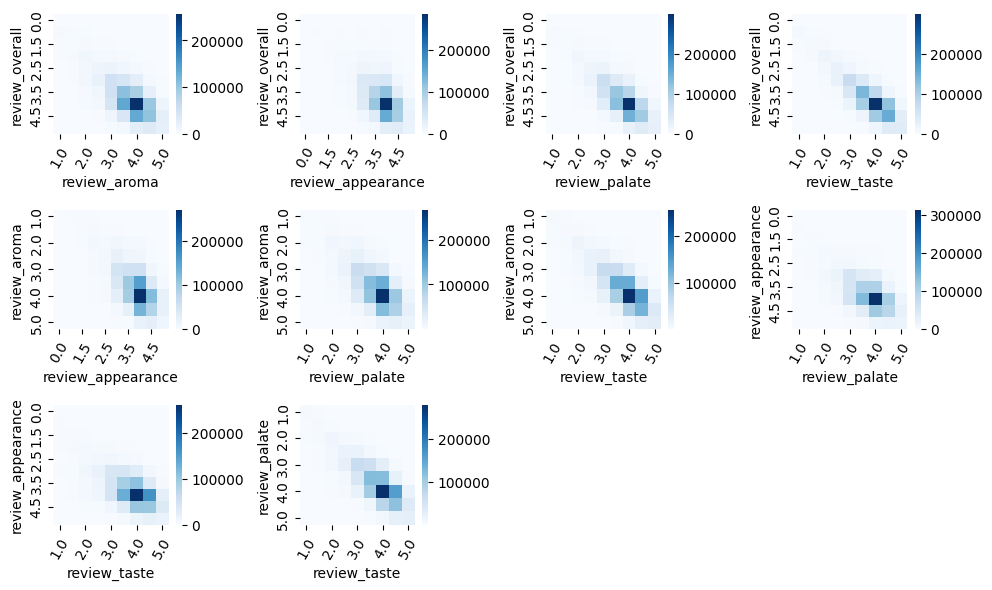

In [92]:
#generate cross-combinations for review scores
#get all pairs of raitng variables
from itertools import combinations
pairs = list(combinations(cols, 2))

#create a subplots figure + axes
fig, axes = plt.subplots(3,4, figsize=(10,6))
#makes axes 1D
axes = axes.flatten()
#loop over axes and plot
for i in range(10):
        #select correct axis
        ax = axes[i]
        #generate crosstable of variables
        cross = pd.crosstab(beer[pairs[i][0]], beer[pairs[i][1]])
        #plot pairwise heatmap
        sb.heatmap(cross, cmap='Blues', ax=ax)
        ax.tick_params(axis='x', rotation=60)
#show results
fig.tight_layout()
fig.delaxes(axes[10])
fig.delaxes(axes[11])
fig.show()

In all the pairwise distributions, the most common outcome is a score of 4 on both ratings, and in general the distributions appear similar - as we saw earlier from the univariate distribution plots, scores most commonly rnage between 3 and 4.5. We'll have to do some analysis to uncover more details about the relationships between the variables.

Let's begin by taking a correlation measure between the score variables. We shouldn't use the Pearson correlation, since it's only valid for continuous and normally distributed data with a linear relationship. Our review score variables are ordinal, so instead, we can use Spearman rank correlation and Kendall's Tau correlation.

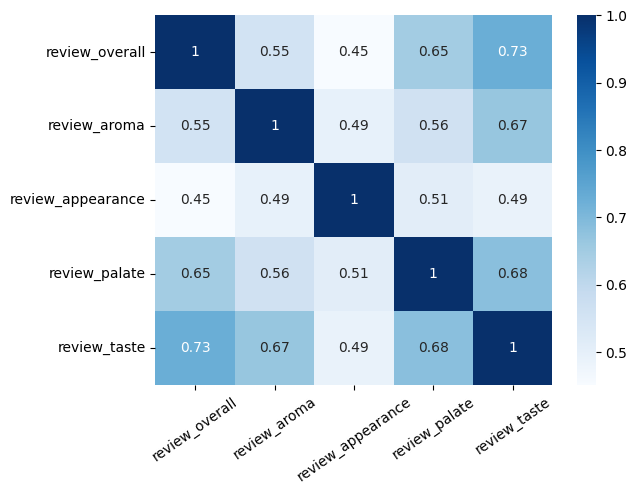

In [93]:
#get spearman correlation matrix for review scores and plot
corr = sb.heatmap(beer[cols].corr(method='spearman'), cmap='Blues', annot=True)
corr.tick_params(axis = 'x', rotation=35)

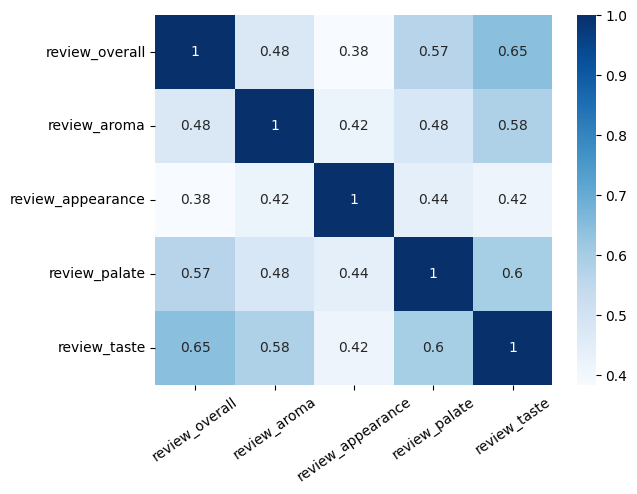

In [94]:
#get kendall correlation matrix for review scores and plot
corr = sb.heatmap(beer[cols].corr(method='kendall'), cmap='Blues', annot=True)
corr.tick_params(axis = 'x', rotation=35)

When comparing two review score variables $x,y$, we say a pair of data points $\{(x_i, y_i), (x_j,y_j)\}$ is *tied* if and only if $x_i = x_j$ or $y_i = y_j$. One feature of our data is that when calculating Spearman or Tau correlations, there will be many pairs. This is because the scores can only be chosen between $0$ and $5$ at intervals of $0.5$, with scores of 4.0 being common for all variables. For example, there are likely to be many ties where $(x_i,y_i) = (x_j,y_j) = (4.0,4.0)$. Let's get some pairwise counts of such ties, just for fun.

In [95]:
#calculate proportion of pairwise data points where review scores are both 4.0
for i in range(10):
    pair = pairs[i]
    print(pair)
    print(
        #get number of rows where scores equal 4.0 and divide by overall length
        round(beer[(beer[pair[0]] == 4.0) & (beer[pair[1]] == 4.0)].shape[0]
              /beer.shape[0],2))

('review_overall', 'review_aroma')
0.17
('review_overall', 'review_appearance')
0.19
('review_overall', 'review_palate')
0.2
('review_overall', 'review_taste')
0.2
('review_aroma', 'review_appearance')
0.18
('review_aroma', 'review_palate')
0.18
('review_aroma', 'review_taste')
0.17
('review_appearance', 'review_palate')
0.21
('review_appearance', 'review_taste')
0.17
('review_palate', 'review_taste')
0.18


As expected, we have a significant amount of ties. It's unsurprising, then, that the Kendall's Tau-b correlation values are smaller than the Spearman rho values, since the rho values can be inflated in the presence of many ties. Otherwise, the two correlation measures correspond closely in terms of the the relative pairwise magnitudes. Perhaps unsurprisingly, both correlation measures indicate the strongest relationship is between taste and overall score, and the weakest relationship is between appearance and overall score. After all, when we drink a glass of beer, we care more about how it tastes than how it looks.

# Part 2: Pouring over the dataset
Now that we've performed some basic analysis on our data, we're ready to move to some more detailed/targeted EDA. In this phase, we'd really like to investigate the data to  Let's start by finding out some basic information about our userbase.

In [96]:
#how many users do we have?
query = "SELECT COUNT(*) num_of_users FROM (SELECT DISTINCT review_profilename FROM beer)"
db.sql(query)

┌──────────────┐
│ num_of_users │
│    int64     │
├──────────────┤
│        32908 │
└──────────────┘

In [97]:
#let's use SQL to group by user and get the review count and average review scores
query = "SELECT review_profilename, AVG(review_overall) avg_overall, \
    AVG(review_aroma) ag_aroma, AVG(review_appearance) avg_appearance, \
    AVG(review_palate) avg_palate, AVG(review_taste) avg_taste, \
    COUNT(*) num_reviews FROM beer \
    GROUP BY review_profilename ORDER BY review_profilename"
#use duckdb to query the data
userScores = db.sql(query).df()

#what's the maximum number of reviews for a single user?
query = "SELECT num_reviews FROM userScores ORDER BY num_reviews DESC LIMIT 1"
db.sql(query)

┌─────────────┐
│ num_reviews │
│    int64    │
├─────────────┤
│        5346 │
└─────────────┘

That's a lot of beer.

In [98]:
#let's see how many users have 1 review
query = "SELECT COUNT(*) users_with_1_review FROM userScores WHERE num_reviews = 1"
db.sql(query)


┌─────────────────────┐
│ users_with_1_review │
│        int64        │
├─────────────────────┤
│               10270 │
└─────────────────────┘

Almost 30% of users have only made one review! It appears that we are not safe from the infamous "cold start" problem. Unfortunately, it will be outside the scope of our project to develop cold start mitigation strategies. We will instead focus on users and beers with multiple reviews so we can make meaningful recommendations with the limited information we have. Cold start mitigation strategies will be discussed in the project write-up. Now, let's have a closer look at the distribution of review counts and average scores. 

**For the review counts, we have a broad range of values to compare, so we'll plot the x-axis using the log-scale.**

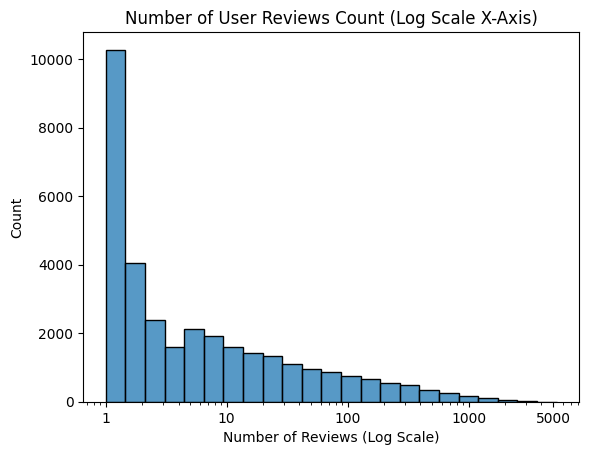

In [99]:
#tool for formatting axis
from matplotlib.ticker import ScalarFormatter
#create figure and axis
fig, ax = plt.subplots()
#plot histogram of user scores
sb.histplot(data = userScores, x='num_reviews', ax = ax, log_scale=(True,False), binwidth=.16)
#format x axis
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xticks([1,10,100,1000,5000])
#label
ax.title.set_text('Number of User Reviews Count (Log Scale X-Axis)')
ax.set_xlabel('Number of Reviews (Log Scale)')
plt.show()

From the histogram, we can see that the number of reviews appears to roughly fit a power law distribution. We can investigate this by plotting on a log-log scale.

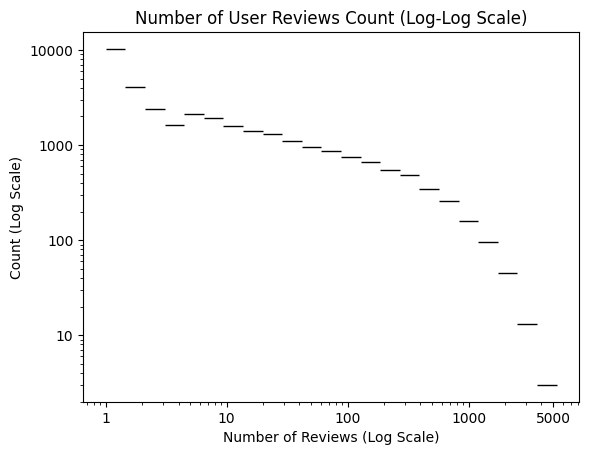

In [100]:
#tool for formatting axis
from matplotlib.ticker import ScalarFormatter
#create figure and axis
fig, ax = plt.subplots()
#plot histogram of user scores
sb.histplot(data = userScores, x='num_reviews', ax = ax, 
            log_scale=(True,True), #both axes on log scale
             binwidth=.16)
#format x and y axis
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_xticks([1,10,100,1000,5000])
#label
ax.title.set_text('Number of User Reviews Count (Log-Log Scale)')
ax.set_xlabel('Number of Reviews (Log Scale)')
ax.set_ylabel('Count (Log Scale)')
plt.show()

If the data really had a power-law distribution, the relationship between number of reviews and count would look roughly linear. We can see that the "middle" of the data is roughly linear, and therefore approximates a power law distribution. The left tail curving up indicates that there are more users with a low review count than if the truly followed a power law distrbution. The right tail curving down indicates that there are even fewer users with many reviews compared to power law distributed data.

Speaking of reviews, we'd like to get an idea of how users behave. Let's look at average user review scores.

/var/folders/b6/811_kpyj6yd5q_vzydsq8cbc0000gn/T/ipykernel_13251/1293515153.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


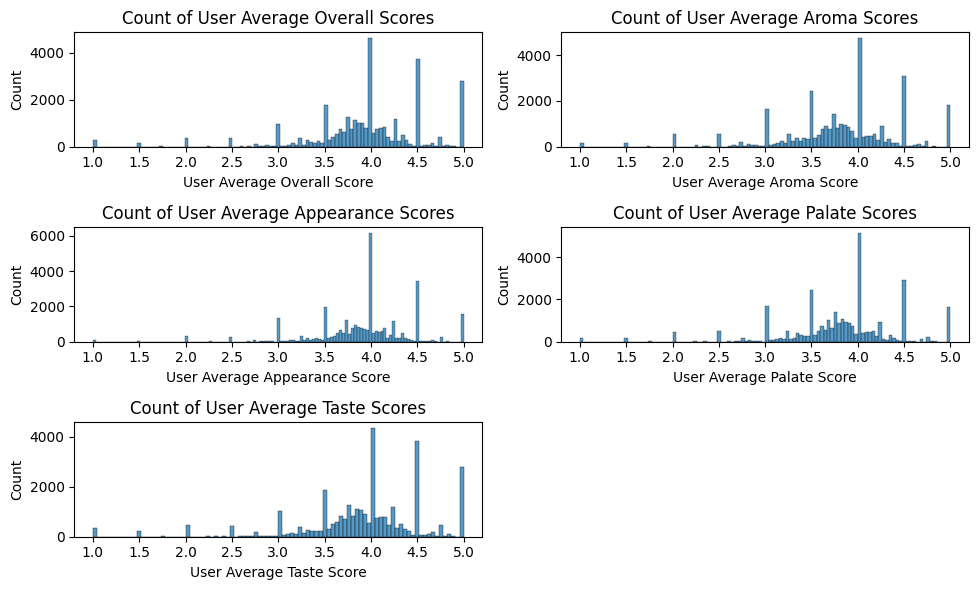

In [101]:
#create a subplots figure + axes
fig, axes = plt.subplots(3,2, figsize=(10,6))
#makes axes 1D
axes = axes.flatten()
cols = userScores.columns[1:6].tolist()
titles = ['Overall', 'Aroma', 'Appearance', 'Palate', 'Taste']
#loop over axes and plot
for i in range(5):
        #select correct axis
        ax = axes[i]
        key = titles[i]
        #plot histogram of user scores
        sb.histplot(data = userScores, x=cols[i], ax = ax)
        #label
        ax.title.set_text(f'Count of User Average {key} Scores')
        ax.set_xlabel(f'User Average {key} Score')
        ax.set_ylabel('Count')

#show results
fig.tight_layout()
fig.delaxes(axes[5])
fig.show()

We see that the averages are getting "spiked" on 1.0, 1.5, etc., most likely because users with a single review will only have been able to select these values. Let's look at the distributions when we ignore users with one review. 

In [109]:
#let's use SQL to group by user and get the review count and average review scores
#but this time we exclude users with only 1 review
query = "SELECT review_profilename, AVG(review_overall) avg_overall, \
    AVG(review_aroma) ag_aroma, AVG(review_appearance) avg_appearance, \
    AVG(review_palate) avg_palate, AVG(review_taste) avg_taste, \
    COUNT(*) num_reviews FROM beer \
    GROUP BY review_profilename \
    HAVING COUNT(*)>1 ORDER BY review_profilename"
#use duckdb to query the data
user_multi_scores = db.sql(query).df()

/var/folders/b6/811_kpyj6yd5q_vzydsq8cbc0000gn/T/ipykernel_13251/165243745.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


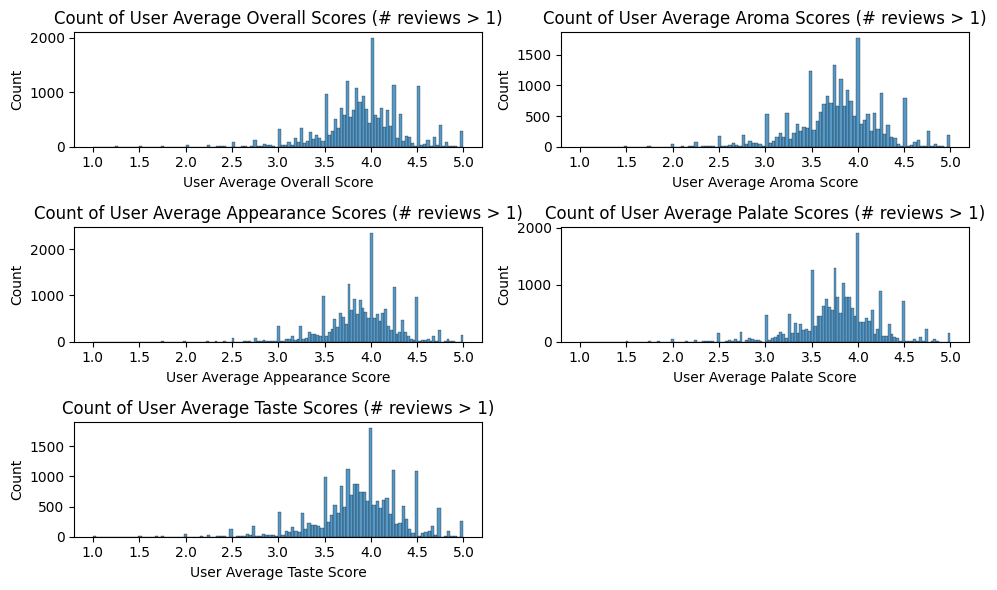

In [110]:
#create a subplots figure + axes
fig, axes = plt.subplots(3,2, figsize=(10,6))
#makes axes 1D
axes = axes.flatten()
#loop over axes and plot
for i in range(5):
        #select correct axis
        ax = axes[i]
        key = titles[i]
        #plot histogram of user scores
        sb.histplot(data = user_multi_scores, x=cols[i], ax = ax)
        #label
        ax.title.set_text(f'Count of User Average {key} Scores (# reviews > 1)')
        ax.set_xlabel(f'User Average {key} Score')
        ax.set_ylabel('Count')

#show results
fig.tight_layout()
fig.delaxes(axes[5])
fig.show()

We can immediately see that the "spikes" on multiples of $\frac{1}{2}$ are much less pronounced (though still present). In general, scores for most attributes tend to "spike" at 3.5, 4, and 4.5, with the most density otherwise between 3.5 and 4.